In [1]:
! pip install -qq func-adl-servicex~=1.0.2
! pip install -qq --upgrade git+https://github.com/matthewfeickert/heputils.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [2]:
from servicex import ServiceXDataset
from func_adl_servicex import ServiceXSourceXAOD

import numpy as np
import matplotlib.pyplot as plt
import mplhep
import heputils

mplhep.set_style("ATLAS")

Get keys for authentication

In [3]:
from google.colab import drive

drive.mount("/content/drive")
!cp "/content/drive/My Drive/atlas-servicex.yaml" ./.servicex

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Perform a query

In [4]:
jet_moments = ["LArQuality", "LArBadHVEnergyFrac", "HECQuality", "EMFrac"]
select_statement = (
    "lambda j: ("
    + ", ".join([f'j.getAttributeFloat("{x}")' for x in jet_moments])
    + ")"
)
print(select_statement)

lambda j: (j.getAttributeFloat("LArQuality"), j.getAttributeFloat("LArBadHVEnergyFrac"), j.getAttributeFloat("HECQuality"), j.getAttributeFloat("EMFrac"))


In [5]:
did = "mc16_13TeV:mc16_13TeV.364700.Pythia8EvtGen_A14NNPDF23LO_jetjet_JZ0WithSW.deriv.DAOD_JETM1.e7142_s3126_r9364_p4128"

dataset = ServiceXDataset(did, max_workers=200, backend_type="xaod")

query = (
    ServiceXSourceXAOD(dataset)
    .SelectMany('lambda e: e.Jets("AntiKt4EMTopoJets")')
    .Where("lambda j: j.pt()/1000>20 and abs(j.eta())<4.5")
    .Select(select_statement)
    .AsPandasDF(tuple(jet_moments))
    .value()
)

query.head()

,LArQuality,LArBadHVEnergyFrac,HECQuality,EMFrac
entry,,,,
0,0.062179,0.265553,0.0,0.860897
1,0.028388,0.075783,0.0,0.925388
2,0.348398,0.000000,0.0,1.000000
3,0.000000,0.065137,0.0,0.753856
4,0.000000,0.177519,0.0,0.708219


In [6]:
def quick_plot(hist, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # get kwargs
    label = kwargs.pop("label", None)
    is_density = kwargs.pop("density", True)
    xlabel = kwargs.pop("xlabel", None)
    ylabel = kwargs.pop("ylabel", None)
    logy = kwargs.pop("logy", True)

    mplhep.histplot(hist, label=label, density=is_density, ax=ax)

    if logy:
        ax.semilogy()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    return ax

Make a first plot:

**Avg LArQ** (LArQuality): The energy-squared weighted average of the LArQ of all cells in a jet

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


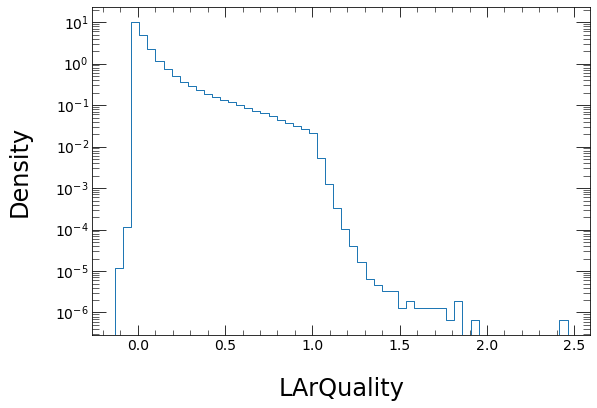

In [7]:
bin_width = 0.05
_range = [-0.2, 2.6]
_bins = int((_range[1] - _range[0]) / bin_width)
hist_LArQuality = heputils.convert.numpy_to_hist(
    *np.histogram(query.LArQuality, bins=_bins)
)

fig, ax = plt.subplots()

quick_plot(
    hist_LArQuality,
    xlabel="LArQuality",
    ylabel="Density",
    density=True,
    ax=ax,
)

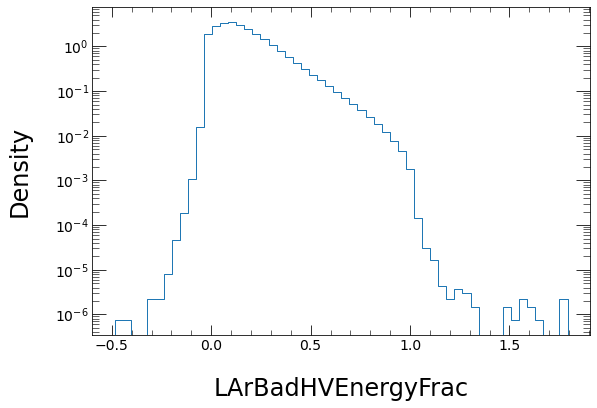

In [8]:
bin_width = 0.05
_range = [-0.2, 2.6]
_bins = int((_range[1] - _range[0]) / bin_width)
hist_LArBadHVEnergyFrac = heputils.convert.numpy_to_hist(
    *np.histogram(query.LArBadHVEnergyFrac, bins=_bins)
)

fig, ax = plt.subplots()
quick_plot(
    hist_LArBadHVEnergyFrac,
    xlabel="LArBadHVEnergyFrac",
    ylabel="Density",
    density=True,
    ax=ax,
)

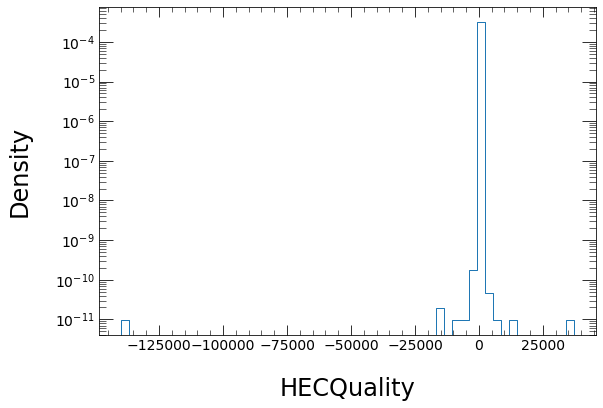

In [9]:
hist_HECQuality = heputils.convert.numpy_to_hist(
    *np.histogram(query.HECQuality, bins=_bins)
)

fig, ax = plt.subplots()
quick_plot(
    hist_HECQuality,
    xlabel="HECQuality",
    ylabel="Density",
    density=True,
    ax=ax,
)

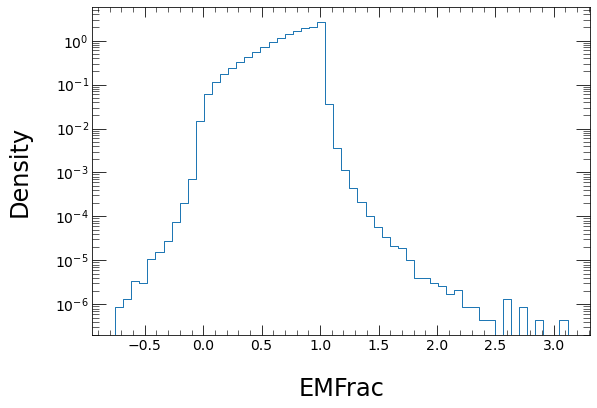

In [11]:
hist_EMFrac = heputils.convert.numpy_to_hist(*np.histogram(query.EMFrac, bins=_bins))

fig, ax = plt.subplots()
quick_plot(
    hist_EMFrac,
    xlabel="EMFrac",
    ylabel="Density",
    density=True,
    ax=ax,
)